In [110]:
import glob
import json
from PIL import Image
import os
import numpy as np 
import scipy.misc
apt_dir = 'multiview'

In [111]:
# Mapping from depth val to real val
with open('data_v2.txt', 'r') as f:
    elems = f.readlines()
    map_val = np.zeros((256))
print(map_val.shape)
for elem in elems:
    cont = elem.split()
    map_val[int(cont[0])] = float(cont[1])

(256,)


In [112]:
# Grab all the cameras
with open('{}/camera_info.json'.format(apt_dir), 'r') as f:
    cameras = json.load(f)
img = glob.glob('{}/*_normal.png'.format(apt_dir))

We first extract the images of interest, those containing a person and a bookshelp

In [113]:

def bin_image_object(input_im, id_objects=[[36,129,138]]): #  # [128,128,42]
    # given image, obtain binary mask where the objects with isntance = id_objects appear
    cols = [np.array(id_object)[None, None, :] for id_object in id_objects]
    imf = np.array(input_im)
    binary_masks = []
    for col in cols:
        img_bin = (imf == col).sum(-1)
        binary_masks.append(img_bin == 3)
    binary_masks = np.concatenate([bm[:, :, None] for bm in binary_masks], axis=-1)
    binary_mask = binary_masks.sum(-1) > 0
    #binary_mask = binary_masks[:,:,0]
    return binary_mask, binary_mask.sum() > 0

In [114]:
ids

[0, 1, 2, 3, 4, 5, 6]

In [129]:
# Given the images of interest, obtan original image (images), depth(depths) and bin_masks which is a binary mask
# with the objects of interest
ids = []
bin_masks = []
depths = []
ids = []
images = []
img = sorted(img)
for im in img:
    idi = int(os.path.basename(im).split('_')[1])-1
    im_seg = im.replace('normal', 'seg_inst')
    img_seg = Image.open(im_seg)
    binmask, presence = bin_image_object(img_seg)
    if presence:
        ids.append(idi)
        depthm = scipy.misc.imread(im.replace('normal', 'depth'), 'YCbCr').astype(np.int32)
        bin_masks.append(binmask)
        formdepthm = map_val[depthm]
        depths.append(formdepthm)
        images.append(Image.open(im))
        

In [130]:
# Obtain the cameras from te images we care about, we multuply projection x world_to_camera

pm = []
pm_names = []
pm_projection = []
for idi in ids:
    idx_camera = [i for i,c in enumerate(cameras) if c['index'] == idi][0]
    cam_params = np.array(cameras[idx_camera]['projection_matrix']).reshape(4,4).transpose()
    word2cam = np.array(cameras[idx_camera]['world_to_camera_matrix']).reshape(4,4).transpose()
    pm_projection.append(cam_params)
    pm.append(np.matmul(cam_params, word2cam))
    pm_names.append(cameras[idx_camera]['name'])

# Code about camera coords and so on

In [168]:
# Code for camera inverse projection, given the binary image, depth image and a projection-world matrix
# Obtains the x,y,z world coordinates
# It also returns an image corresponding to the world coordinates projected into matrix2
# Ratio leave is the sampling ration of our binary masks, for faster performance
def convertCameraCoords(ratio_leave, bin_image, depth_image, matrix=None, cam_mat=None, matrix2=None, inv_matrix=None):
    if matrix2 is None:
        matrix2 = matrix
    h, w = bin_image.shape
    coords = np.where(bin_image)
    y = 1.-2*(coords[0]*1./h) # -1 to 1
    x = 2*(coords[1]*1./w)-1. # -1 to 1
    wc = depth_image[:,:][bin_image].copy()
    z = wc*(-1.*cam_mat[2,2]) + cam_mat[2,3]
    print(x.shape, y.shape, z.shape)
    
    wc = wc[::ratio_leave]
    x = x[::ratio_leave]*wc
    y = y[::ratio_leave]*wc
    z = z[::ratio_leave]
    if matrix is not None:
        if inv_matrix is not None:
            invmat = inv_matrix
        else:
            invmat = np.linalg.inv(matrix)
        coords = np.concatenate([x[None, :],y[None, :], z[None, :], wc[None, :]], axis=0)
        newpos = np.matmul(invmat, coords).copy()
        # newpos = newpos*depth_image[:, :][bin_image][None,:]
        x = newpos[0,:]
        y = newpos[1, :]
        z = newpos[2,:]
        print(y)
        # Project back
        newcoords = np.matmul(matrix2, newpos)
        newimg = np.zeros(bin_image.shape)
        nx = newcoords[0, :]
        ny = newcoords[1, :]
        nw = newcoords[3, :]
        print(nx.shape, nw.shape)
        clipx = nx/nw # -1 to 1
        clipy = ny/nw # -1 to 1
        nx = np.array(w*((clipx+1)/2.)).astype(np.int32)
        ny = np.array(h*(1- (clipy+1)/2.)).astype(np.int32)
        indices = [ir for ir in range(len(nx.tolist())) if 0 <= nx[ir] < w and 0 <= ny[ir] < h]
        nx = nx[indices]
        ny = ny[indices]
        newimg[ny-1, nx-1] = True
    else:
        newimg = bin_image

    return x,y,z,newimg.astype(np.bool)

In [166]:
pm_names

[u'Camera_1',
 u'Camera_2',
 u'Camera_3',
 u'Camera_4',
 u'Camera_5',
 u'Camera_6',
 u'Camera_7']

# Transforming according to the projection matrix

7
Camera_1
((3938,), (3938,), (3938,))
[ 0.516  0.516  0.516 ..., -0.476 -0.476 -0.476]
((1969,), (1969,))
Camera_2
((5429,), (5429,), (5429,))
[ 0.522  0.522  0.522 ..., -0.502 -0.474 -0.474]
((2715,), (2715,))
Camera_3
((3648,), (3648,), (3648,))
[ 0.513  0.513  0.513 ..., -0.492 -0.462 -0.492]
((1824,), (1824,))
Camera_4
((4444,), (4444,), (4444,))
[ 0.511  0.511  0.511 ..., -0.494 -0.494 -0.494]
((2222,), (2222,))
Camera_5
((2310,), (2310,), (2310,))
[ 0.503  0.503  0.503 ..., -0.450 -0.505 -0.505]
((1155,), (1155,))
Camera_6
((3217,), (3217,), (3217,))
[ 0.522  0.522  0.522 ..., -0.437 -0.437 -0.437]
((1609,), (1609,))
Camera_7
((3136,), (3136,), (3136,))
[ 0.488  0.488  0.488 ...,  0.488  0.488  0.488]
((1568,), (1568,))


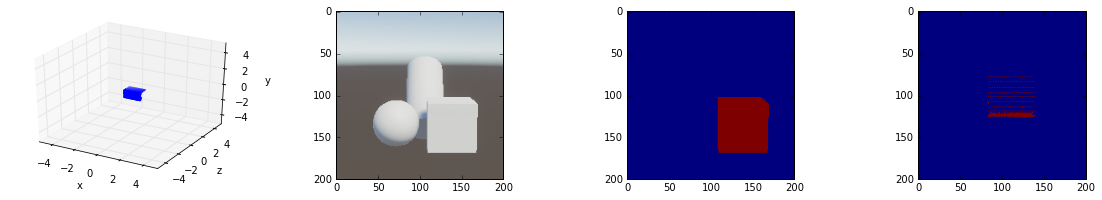

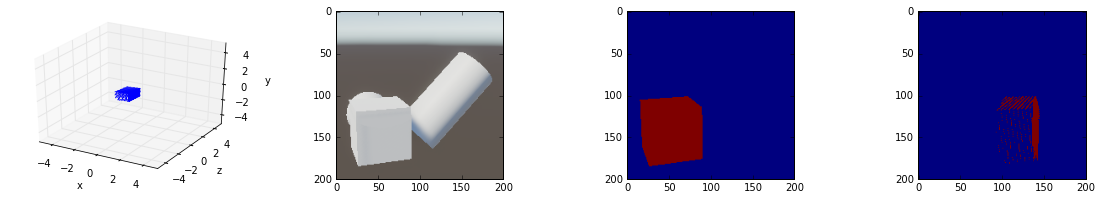

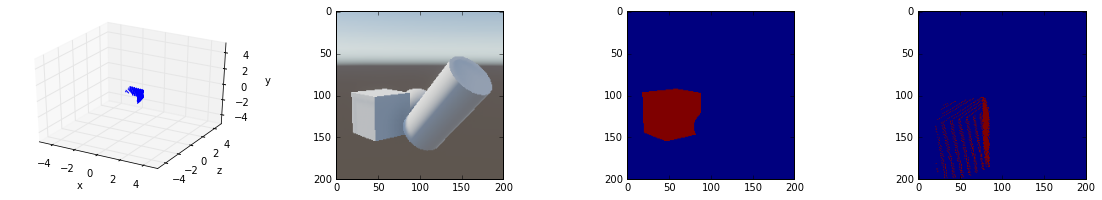

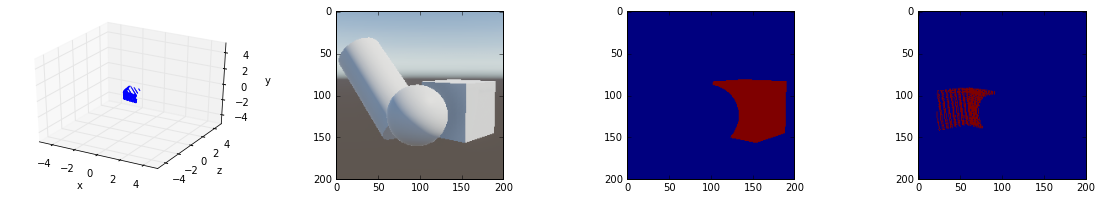

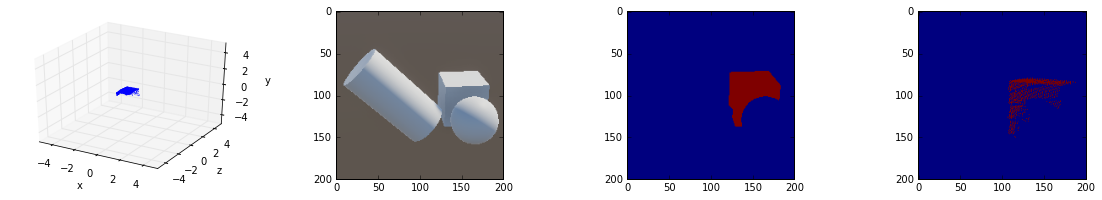

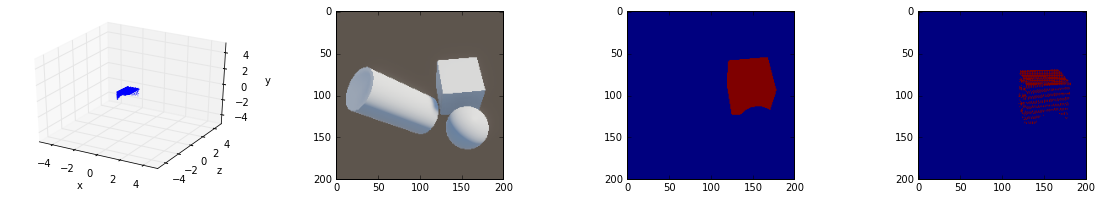

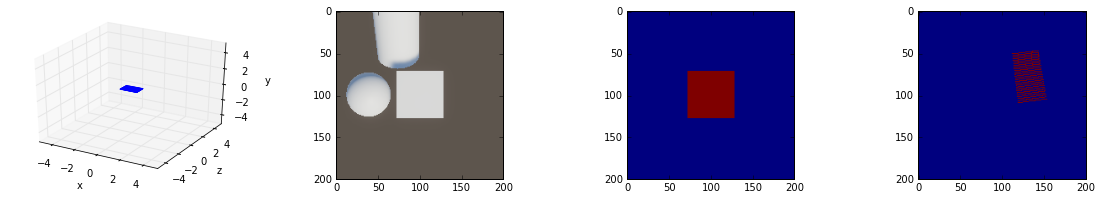

In [179]:
# Given our images of interest, fins the wolrd projection and projects into the previous camera matrix
%matplotlib inline
from IPython.core.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage
ratio_leave = 2
all_x, all_y, all_z, all_img = [], [], [], []
print(len(pm))
for img_id in range(7): # I start at 12, you can start at 0
    print(pm_names[img_id])
    fig = plt.figure(figsize=(20,3))
    ax = fig.add_subplot(141, projection='3d')
    x,y,z,imgnew = convertCameraCoords(ratio_leave, bin_masks[img_id], depths[img_id], 
                                        pm[img_id], pm_projection[img_id], pm[img_id-1])    
    imig = np.array(images[img_id]).reshape(-1,3)[bin_masks[img_id].reshape(-1)][::ratio_leave, :]/255.
    all_x.append(x), all_y.append(y), all_z.append(z), all_img.append(imig)
    ax.scatter(x,z,y, s=1, lw=0)    
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y');
    ax2 = fig.add_subplot(142)
    ax2.imshow(images[img_id])
    ax2 = fig.add_subplot(143)
    ax2.imshow(bin_masks[img_id])
    ax3 = fig.add_subplot(144)
    ax3.imshow(imgnew)
    ax.set_xlim(-5,5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-5, 5)
all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)
all_z = np.concatenate(all_z)
all_img = np.concatenate(all_img)
# %matplotlib inline
# fig = plt.figure(figsize=(15,4))
# ax = fig.add_subplot(111, projection='3d')
# print(all_x.shape, all_img.shape, x.shape)

# ax.scatter(all_x, all_z, all_y, s=1, c=all_img, lw=0)

# ax.set_xlim(-5,5)
# ax.set_ylim(-5, 5)
# ax.set_zlim(-5, 5)


# MORE DEBUGGING CODE - RELEVANT CODE ENDS HERE

# Without doing any transformation

In [ ]:
%matplotlib inline
from IPython.core.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

all_x, all_y, all_z, all_img = [], [], [], []

for img_id in range(len(pm)):
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(131, projection='3d')
    x,y,z,_ = convertCameraCoords(bin_masks[img_id], depths[img_id], None)
    imig = np.array(images[img_id]).reshape(-1,3)[bin_masks[img_id].reshape(-1)][::10, :]/255.
    all_x.append(x), all_y.append(y), all_z.append(z), all_img.append(imig)
    ax.scatter(x,y,z, s=1, c=imig, lw=0)
    ax2 = fig.add_subplot(132)
    ax2.imshow(images[img_id])
    ax2 = fig.add_subplot(133)
    ax2.imshow(bin_masks[img_id])

all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)
all_z = np.concatenate(all_z)
all_img = np.concatenate(all_img)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111, projection='3d')
print(all_x.shape, all_img.shape, x.shape)
ax.scatter(all_x, all_y, all_z, s=1, c=all_img, lw=0)
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.ylim(-5, 10)

In [ ]:
%matplotlib inline
from IPython.core.display import display
import matplotlib.pyplot as plt
plt.close()
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
pm = [x['projection_matrix'] for x in cameras if x['index'] in ids]
xs, zs, ys = [], [], []
print(len(pm))
for it,p  in enumerate(pm):
   print(ids[it])
   display(Image.open('{}/{:03}_normal.png'.format(apt_dir, ids[it])))
   #display(Image.fromarray(bin_masks[it].astype(np.uint8)*255))
   proj = np.array(p).reshape(4,4).transpose()
   x, y, z = proj[0,3], proj[1,3], proj[2,3]
   xs.append(x)
   ys.append(y)
   zs.append(z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, s=2)

plt.show()

In [ ]:
np.array(pm[6]).reshape(4,4).transpose()

In [ ]:
np.array(cameras[0]['projection_matrix']).reshape(4,4).transpose()

In [149]:
pm[-1].shape

(4, 4)

In [65]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
for il in range(1, 8):
    print('---')
    print(cameras[il]['name'])
    print(np.array(cameras[il]['world_to_camera_matrix']).reshape(4,4).transpose())
    print('\n')
    print(np.array(cameras[il]['projection_matrix']).reshape(4,4).transpose())

---
Camera_2
[[ 0.327  0.000  0.945 -0.798]
 [-0.192  0.979  0.066 -0.658]
 [ 0.925  0.204 -0.320 -6.123]
 [ 0.000  0.000  0.000  1.000]]


[[ 2.488  0.000  0.000  0.000]
 [ 0.000  3.732  0.000  0.000]
 [ 0.000  0.000 -1.024 -0.607]
 [ 0.000  0.000 -1.000  0.000]]
---
Camera_3
[[-0.747  0.000  0.665 -0.957]
 [-0.096  0.990 -0.108 -0.445]
 [ 0.658  0.144  0.739 -7.630]
 [ 0.000  0.000  0.000  1.000]]


[[ 2.488  0.000  0.000  0.000]
 [ 0.000  3.732  0.000  0.000]
 [ 0.000  0.000 -1.024 -0.607]
 [ 0.000  0.000 -1.000  0.000]]
---
Camera_4
[[ 0.667  0.000 -0.745  0.733]
 [ 0.076  0.995  0.068 -0.250]
 [-0.741  0.102 -0.663 -5.990]
 [ 0.000  0.000  0.000  1.000]]


[[ 2.488  0.000  0.000  0.000]
 [ 0.000  3.732  0.000  0.000]
 [ 0.000  0.000 -1.024 -0.607]
 [ 0.000  0.000 -1.000  0.000]]
---
Camera_5
[[-0.106 -0.000 -0.994  1.017]
 [ 0.395  0.918 -0.042 -0.078]
 [-0.913  0.397  0.097 -7.656]
 [ 0.000  0.000  0.000  1.000]]


[[ 2.488  0.000  0.000  0.000]
 [ 0.000  3.732  0.000  0.000]
 [ 

IndexError: list index out of range

In [78]:
np.matmul(pm[-1], np.array([0,0.5,0,1]).transpose())

array([ 0.000,  0.000,  6.194,  6.640])

In [109]:
6.640*1.024 - 0.607

6.19236

In [86]:
formdepthm = 0.00045*(141*141) - 0.02*141 + 0.6

In [87]:
formdepthm

6.72645

In [83]:
(144./255)*2 - 1

0.12941176470588234

In [76]:
c1 = np.array(cameras[-1]['world_to_camera_matrix']).reshape(4,4).transpose()
np.matmul(c1, np.array([0,0.5,0,1]).transpose())

array([ 0.000,  0.000, -6.640,  1.000])

In [90]:
pm_inv[3]

array([[ 0.268,  0.020,  8.085, -7.540],
       [ 0.000,  0.267, -1.416,  1.348],
       [-0.300,  0.018,  5.615, -5.088],
       [ 0.000,  0.000, -1.647,  1.687]])

In [144]:
map_val[141]

6.6517156666666679